# 统计学笔记

## 第一章 信息图形化

本节引入pandas，matplotlib，seaborn来分析1955-2005年每年前500名电影利润数据。

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="darkgrid")
df = pd.read_csv(r"C:\Users\Nero\Documents\fortune500.csv")
#将列名重命名
df.columns = ['year', 'rank', 'company', 'revenue', 'profit']




In [2]:
df.head()

,year,rank,company,revenue,profit
0,1955,1,General Motors,9823.5,806
1,1955,2,Exxon Mobil,5661.4,584.8
2,1955,3,U.S. Steel,3250.4,195.4
3,1955,4,General Electric,2959.1,212.6
4,1955,5,Esmark,2510.8,19.1


In [3]:
df.tail()


,year,rank,company,revenue,profit
25495,2005,496,Wm. Wrigley Jr.,3648.6,493
25496,2005,497,Peabody Energy,3631.6,175.4
25497,2005,498,Wendy's International,3630.4,57.8
25498,2005,499,Kindred Healthcare,3616.6,70.6
25499,2005,500,Cincinnati Financial,3614.0,584


查看数据量：


In [4]:
len(df)

25500

总共有 25500 条数据，刚好就是 500 家公司从 1955 到 2005 的数据量。

接着，我们再查看数据集是否和我们希望导入的一样，一个简单的检查方法就是查看数据类型是否正确：

In [5]:
df.dtypes

year         int64
rank         int64
company     object
revenue    float64
profit      object
dtype: object

这里可以发现 profit 数据类型居然是 object 而不是和收入 revenue 一样的float64 类型，这表示其中可能包含一些非数字的数值，因此我们需要检查一下：
**??代码不太懂**

In [6]:
non_numberic_profits = df.profit.str.contains('[^0-9.-]')
df.loc[non_numberic_profits].head()

,year,rank,company,revenue,profit
228,1955,229,Norton,135.0,N.A.
290,1955,291,Schlitz Brewing,100.0,N.A.
294,1955,295,Pacific Vegetable Oil,97.9,N.A.
296,1955,297,Liebmann Breweries,96.0,N.A.
352,1955,353,Minneapolis-Moline,77.4,N.A.


输出结果表明确实存在非整数的数值，而是是 N.A，然后我们需要确定是否包含其他类型的数值：

In [7]:
set(df.profit[non_numberic_profits])

{'N.A.'}

输出结果表示只有 N.A ，那么该如何处理这种缺失情况呢，这首先取决有多少行数据缺失了 profit :

In [8]:
len(df.profit[non_numberic_profits])

369

369 条数据缺失，相比于总共 25500 条数据，仅占据 1.5% 左右。如果缺失的数据随着年份的变化符合正态分布，那么最简单的方法就是直接删除这部分数据集，代码如下所示:

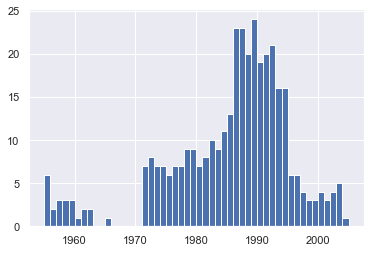

In [33]:
bin_sizes, _, _ = plt.hist(df.year[non_numberic_profits], bins=range(1955, 2006))

从结果看，缺失数据最多的一年也就是 25 条也不到，相比每年 500 条数据，最多占据 4%，并且只有在 90 年代的数据缺失会超过 20 条，其余年份基本在 10 条以下，因此可以接受直接删除缺失值的数据，代码如下：



In [10]:
df = df.loc[~non_numberic_profits]
df.profit = df.profit.apply(pd.to_numeric)

In [11]:
len(df)

25131

In [12]:
df.dtypes

year         int64
rank         int64
company     object
revenue    float64
profit     float64
dtype: object

## 使用matplotlib绘制图表
绘制随年份变化的平均利润表，绘制收入随年份变化的情况

In [16]:
group_by_year = df.loc[:, ['year', 'revenue', 'profit']].groupby('year')
avgs = group_by_year.mean()
x = avgs.index
y1 = avgs.profit
def plot(x, y, ax, title, y_label):
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.plot(x, y)
    ax.margins(x=0, y=0)

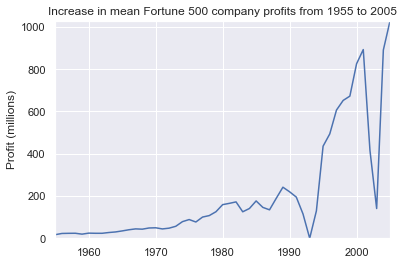

In [14]:
fig, ax = plt.subplots()
plot(x, y1, ax, 'Increase in mean Fortune 500 company profits from 1955 to 2005', 'Profit (millions)')

收入的变化情况：

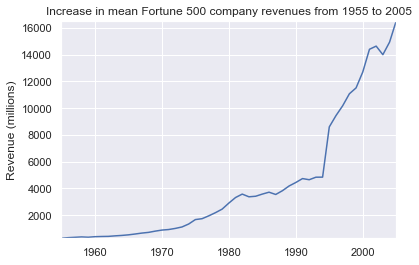

In [17]:
y2 = avgs.revenue
fig, ax = plt.subplots()
plot(x, y2, ax, 'Increase in mean Fortune 500 company revenues from 1955 to 2005', 'Revenue (millions)')

添加了利润和收入的标准差情况，用于反馈同一年不同公司的收入或者利润差距，如下图所示：

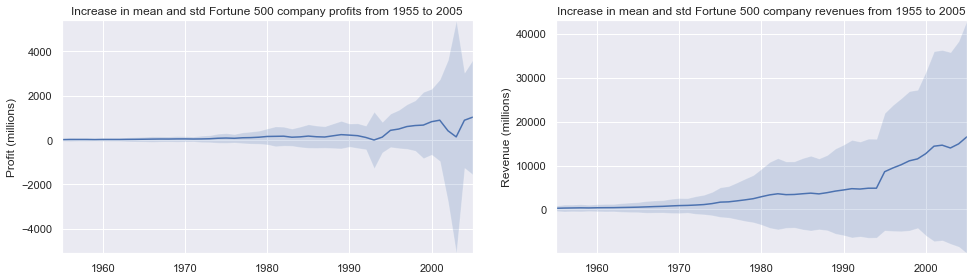

In [18]:
def plot_with_std(x, y, stds, ax, title, y_label):
    ax.fill_between(x, y - stds, y + stds, alpha=0.2)
    plot(x, y, ax, title, y_label)
fig, (ax1, ax2) = plt.subplots(ncols=2)
title = 'Increase in mean and std Fortune 500 company %s from 1955 to 2005'
stds1 = group_by_year.std().profit.values
stds2 = group_by_year.std().revenue.values
plot_with_std(x, y1.values, stds1, ax1, title % 'profits', 'Profit (millions)')
plot_with_std(x, y2.values, stds2, ax2, title % 'revenues', 'Revenue (millions)')
fig.set_size_inches(14, 4)
fig.tight_layout()

### 饼图 
方便看出总体为1的百分比的占比


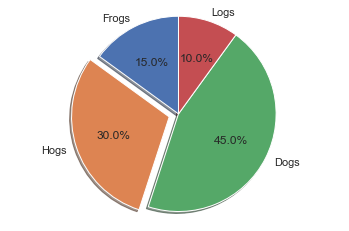

In [25]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### 堆积条形图
想比较频数时，可以使用它。但是不好看出百分数。

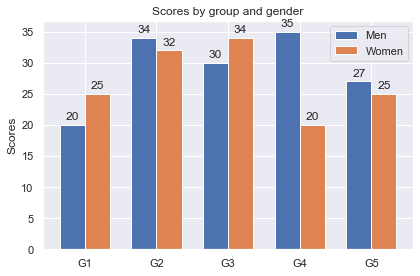

In [22]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### 分段条形图
可以同时体现频数和百分数

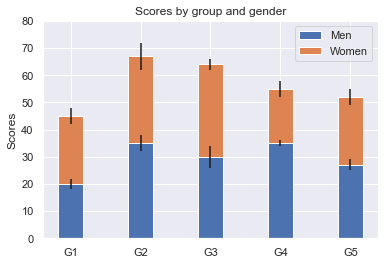

In [27]:
N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

直方图如下

(array([2.0000e+00, 8.0000e+00, 2.2000e+01, 1.4100e+02, 5.9400e+02,
        1.6320e+03, 3.8020e+03, 7.6830e+03, 1.2581e+04, 1.6390e+04,
        1.7829e+04, 1.5857e+04, 1.1392e+04, 6.8180e+03, 3.3470e+03,
        1.3060e+03, 4.5100e+02, 1.0800e+02, 3.4000e+01, 3.0000e+00]),
 array([-0.05590616,  0.4304746 ,  0.91685536,  1.40323611,  1.88961687,
         2.37599763,  2.86237839,  3.34875915,  3.83513991,  4.32152067,
         4.80790142,  5.29428218,  5.78066294,  6.2670437 ,  6.75342446,
         7.23980522,  7.72618598,  8.21256674,  8.69894749,  9.18532825,
         9.67170901]),
 <a list of 20 Patch objects>)

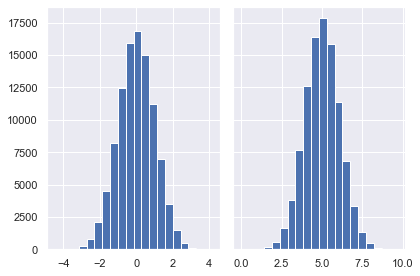

In [32]:
N_points = 100000
n_bins = 20

# Generate a normal distribution, center at x=0 and y=5
x = np.random.randn(N_points)
y = .4 * x + np.random.randn(100000) + 5

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=n_bins)
axs[1].hist(y, bins=n_bins)

直方图2 


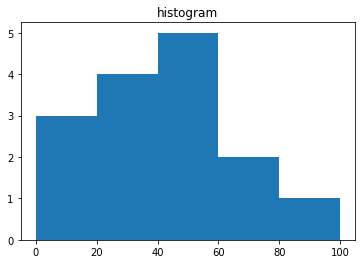

In [6]:
a = np.array([22,87,5,43,56,73,55,54,11,20,51,5,79,31,27]) 
plt.hist(a, bins =  [0,20,40,60,80,100]) 
plt.title("histogram") 
plt.show()

## 第二章 平均数，中位数和众数

## 第三章 分散性和变异性的量度
### 距 四分位数 方差 标准差 标准分

## 第四章 概率计算 
### 维恩图 互斥事件和相交事件 概率树 全概率公式 贝叶斯定理


## 第五章 离散概率分布的运用
### 期望 线性变换

## 第六章 排列组合
### 排列 组合


## 第七章 几何分布 二项分布和泊松分布

## 第八章 正态分布及运用
### 正态概率计算

## 第九章 超越正态分布

## 第十章 抽取样本
### 偏倚来源 确定抽样空间 简单随机抽样 分层抽样 整群抽样 系统抽样

## 第十一章 通过样本预测总体
### 点估计量

## 第十二章 置信区间的构建


## 第十三章 假设检验的运用
### 拒绝域

## 第十四章 卡方分布